Reference paper (not my work) - http://www.ivanpoupyrev.com/wp-content/uploads/2017/01/siggraph_final.pdf
Some experimental code to see how well gesture recognition works when using a simple CNN to do frame-by-fram gesture classification. This is a baseline model. Better results will be achieved when some memory is introduced - CNN + LSTM model

In [1]:
import h5py
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import sklearn
from sklearn.model_selection import train_test_split
import torch.optim as optim

In [2]:
use_channel = 0
file_name = 'D:/SoliData/dsp/4_0_3.h5'
gesture = h5py.File(file_name, 'r')
list(gesture.keys())
with h5py.File(file_name, 'r') as f:
    # Data and label are numpy arrays
    data = f['ch{}'.format(use_channel)][()]
    label = f['label'][()]

In [3]:
data.max()

1.0

In [4]:
image = data.reshape(-1, 32, 32)
image.shape

(62, 32, 32)

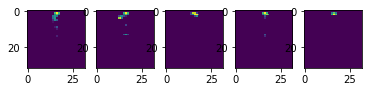

In [5]:
n = 5
frames = np.linspace(0, image.shape[0] - 1, n)
frames = [int(x) for x in frames]
for i in range(1, n + 1):
    plt.subplot(1, n, i)
    plt.imshow(image[frames[i - 1],:])

In [6]:
with open('D:/deep-soli/config/file_half.json', 'r') as fp:
    train_val_split = json.load(fp)

In [7]:
n_classes = 11
path = 'D:/SoliData/dsp/'
for i, name in enumerate(train_val_split['train']):
    file_name = path + name + '.h5'
    with h5py.File(file_name, 'r') as f:
        # Data and label are numpy arrays
        data = f['ch{}'.format(use_channel)][()]
        label = f['label'][()]
        data = data.reshape(-1, 32, 32)
        data = data[:, None]
        data = data.reshape(-1, 1, 32, 32)
        label = np.eye(n_classes)[label]
        if i == 0:
            train_data = data
            train_labels = label
        else:
            train_data = np.vstack((train_data, data))
            train_labels = np.vstack((train_labels, label))

In [8]:
print(train_data.shape, train_labels.shape)

(85531, 1, 32, 32) (85531, 1, 11)


In [9]:
train_labels = train_labels.squeeze()
train_labels.shape

(85531, 11)

In [10]:
X = train_data
y = train_labels

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.5, test_size = 0.5)
X_train = torch.from_numpy(X_train)
X_val = torch.from_numpy(X_val)
y_train = torch.from_numpy(y_train)
y_val = torch.from_numpy(y_val)

In [12]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
val_dataset = torch.utils.data.TensorDataset(X_val, y_val)

In [13]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset,
                                     batch_size=batch_size,
                                     shuffle=True,
                                     num_workers=2,
                                     pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     num_workers=2,
                                     pin_memory=True)

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding = (1, 1))
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 16, 3, padding = (1, 1))
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 8 * 16, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, n_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [16]:
model = Net()
device = torch.device("cuda")
model.to(device)

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=11, bias=True)
)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [18]:
n_epochs = 10
for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, batch in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = batch
        inputs = inputs.to(device, dtype = torch.float)
        labels = torch.argmax(labels, dim = 1)
        labels = labels.to(device, dtype = torch.int64)
#         print(inputs.shape, labels.shape)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
#         print(outputs.shape, type(outputs))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.195
[1,  2000] loss: 1.194
[2,  1000] loss: 1.194
[2,  2000] loss: 1.193
[3,  1000] loss: 1.191
[3,  2000] loss: 1.187
[4,  1000] loss: 1.050
[4,  2000] loss: 0.961
[5,  1000] loss: 0.861
[5,  2000] loss: 0.832
[6,  1000] loss: 0.780
[6,  2000] loss: 0.762
[7,  1000] loss: 0.740
[7,  2000] loss: 0.729
[8,  1000] loss: 0.713
[8,  2000] loss: 0.704
[9,  1000] loss: 0.688
[9,  2000] loss: 0.684
[10,  1000] loss: 0.664
[10,  2000] loss: 0.661
Finished Training


In [19]:
path = 'D:/SoliData/dsp/'
for i, name in enumerate(train_val_split['eval']):
    file_name = path + name + '.h5'
    with h5py.File(file_name, 'r') as f:
        # Data and label are numpy arrays
        data = f['ch{}'.format(use_channel)][()]
        label = f['label'][()]
        data = data.reshape(-1, 32, 32)
        data = data[:, None]
        data = data.reshape(-1, 1, 32, 32)
        label = np.eye(n_classes)[label]
        if i == 0:
            test_data = data
            test_labels = label
        else:
            test_data = np.vstack((test_data, data))
            test_labels = np.vstack((test_labels, label))

In [20]:
print(test_data.shape, test_labels.shape)

(83926, 1, 32, 32) (83926, 1, 11)


In [21]:
test_labels = test_labels.squeeze()
test_labels.shape

(83926, 11)

In [22]:
X_test = torch.from_numpy(test_data)
y_test = torch.from_numpy(test_labels)

In [23]:
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                     batch_size=batch_size,
                                     shuffle=False,
                                     num_workers=2,
                                     pin_memory=True)

In [30]:
correct = 0
total = 0
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device, dtype = torch.float)
        labels = torch.argmax(labels, dim = 1)
        labels = labels.to(device, dtype = torch.int64)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [31]:
print('Accuracy on {} test frames = {:.2f}'.format(
     total, 100 * correct / total))

Accuracy on 83926 test frames = 52.19
